Take from GABRIEL ATKIN Fish Image Species Classification

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
from IPython.display import Image, display
import matplotlib.cm as cm

import tensorflow as tf 

import os
import shutil
from tqdm import tqdm
from random import shuffle

import cv2
from glob import glob

from tensorflow.keras import backend as K
import random
import albumentations as A
from sklearn.model_selection import train_test_split, StratifiedKFold

from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.applications.efficientnet import *

In [2]:
image_dir = Path('../input/snake-dataset-india/Snake Images')

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

In [3]:
image_df.head(5)

,Filepath,Label
0,../input/snake-dataset-india/Snake Images/test...,Venomous
1,../input/snake-dataset-india/Snake Images/test...,Venomous
2,../input/snake-dataset-india/Snake Images/test...,Venomous
3,../input/snake-dataset-india/Snake Images/test...,Venomous
4,../input/snake-dataset-india/Snake Images/test...,Venomous


In [4]:
# Shuffle the DataFrame and reset index
image_df = image_df.sample(frac=1).reset_index(drop = True)

# Show the result
image_df.head(5)

,Filepath,Label
0,../input/snake-dataset-india/Snake Images/trai...,Venomous
1,../input/snake-dataset-india/Snake Images/trai...,Venomous
2,../input/snake-dataset-india/Snake Images/test...,Non Venomous
3,../input/snake-dataset-india/Snake Images/trai...,Non Venomous
4,../input/snake-dataset-india/Snake Images/trai...,Non Venomous


In [5]:
image_df.shape

(1944, 2)

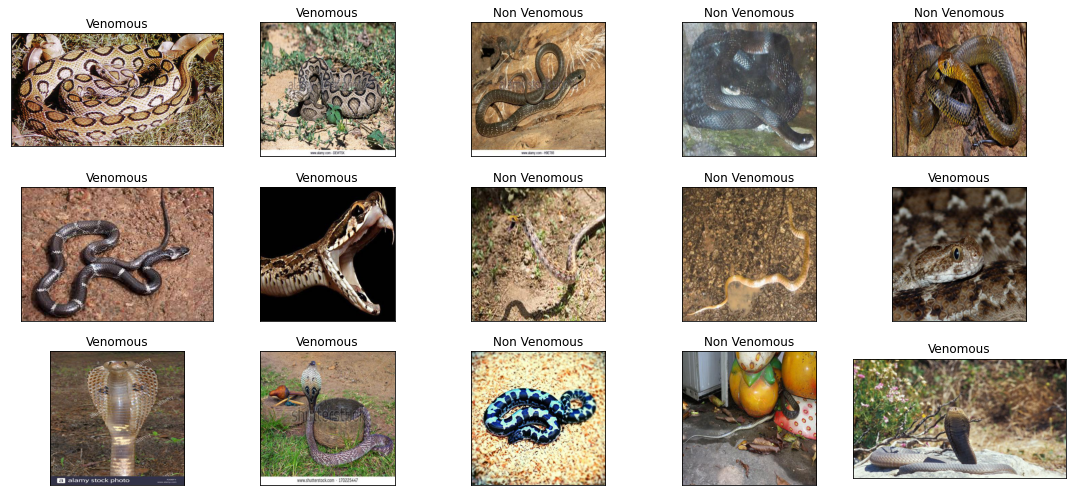

In [6]:
# Display 20 picture of the dataset with their labels
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[i]))
    ax.set_title(image_df.Label[i])
plt.tight_layout()
plt.show()

In [7]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df, train_size=0.9, shuffle=True, random_state=1)

In [8]:
train_df.shape

(1749, 2)

In [9]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [10]:
train_df.head(5)

,Filepath,Label
1836,../input/snake-dataset-india/Snake Images/trai...,Venomous
1821,../input/snake-dataset-india/Snake Images/trai...,Venomous
1301,../input/snake-dataset-india/Snake Images/trai...,Non Venomous
1753,../input/snake-dataset-india/Snake Images/trai...,Non Venomous
8,../input/snake-dataset-india/Snake Images/trai...,Non Venomous


In [11]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 1400 validated image filenames belonging to 2 classes.
Found 349 validated image filenames belonging to 2 classes.
Found 195 validated image filenames belonging to 2 classes.


In [12]:
def create_model(input_shape=(224, 224, 3)):
    
    inputs = Input(input_shape)
    base_model = EfficientNetB1(input_shape=input_shape, include_top=False, classes=2)
    
    x = base_model(inputs)
    
    x = GlobalAveragePooling2D()(x)
#     x = Dropout(0.1)(x)
    
    x = Dense(56, activation='relu')(x)
    x = Dropout(0.1)(x)
    
    outputs = Dense(2, activation='sigmoid')(x)
    
    model = Model(inputs, outputs)
    
    return model

In [13]:
K.clear_session()

model = create_model((224, 224, 3))
# model = load_model('models/checkpoint/EfficientNetB0.h5')

metrics = [
    'accuracy',
    'AUC'
]



2022-11-07 04:48:25.155073: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-07 04:48:25.248233: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-07 04:48:25.249094: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-07 04:48:25.250736: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

27033600/27018416 [==============================] - 0s 0us/step


In [14]:
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=metrics)

In [15]:
checkpoint_path = 'models/EfficientNetB1/model_224.h5'

callbacks = [
    EarlyStopping(monitor='val_loss', mode='min', patience=15, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', mode='min', factor=0.1, patience=5, min_lr=0.000001, verbose=1),
    ModelCheckpoint(monitor='val_loss', mode='min', filepath=checkpoint_path, verbose=1, save_best_only=True, save_weights_only=False)
]

In [16]:
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=25,
    callbacks=callbacks
)

2022-11-07 04:48:31.904018: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/25


2022-11-07 04:48:44.393936: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


44/44 [==============================] - 39s 457ms/step - loss: 0.4985 - accuracy: 0.7514 - auc: 0.8304 - val_loss: 0.6860 - val_accuracy: 0.5673 - val_auc: 0.5578

Epoch 00001: val_loss improved from inf to 0.68602, saving model to models/EfficientNetB1/model_224.h5


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/25
44/44 [==============================] - 16s 363ms/step - loss: 0.2493 - accuracy: 0.9086 - auc: 0.9603 - val_loss: 0.9015 - val_accuracy: 0.4327 - val_auc: 0.4350

Epoch 00002: val_loss did not improve from 0.68602
Epoch 3/25
44/44 [==============================] - 16s 362ms/step - loss: 0.1900 - accuracy: 0.9229 - auc: 0.9759 - val_loss: 0.7548 - val_accuracy: 0.4327 - val_auc: 0.4497

Epoch 00003: val_loss did not improve from 0.68602
Epoch 4/25
44/44 [==============================] - 16s 363ms/step - loss: 0.1217 - accuracy: 0.9557 - auc: 0.9897 - val_loss: 1.0839 - val_accuracy: 0.4327 - val_auc: 0.4304

Epoch 00004: val_loss did not improve from 0.68602
Epoch 5/25
44/44 [==============================] - 16s 362ms/step - loss: 0.1122 - accuracy: 0.9600 - auc: 0.9911 - val_loss: 2.4567 - val_accuracy: 0.4355 - val_auc: 0.4327

Epoch 00005: val_loss did not improve from 0.68602
Epoch 6/25
44/44 [==============================] - 16s 358ms/step - loss: 0.1126 - accuracy

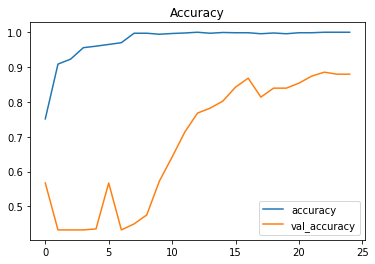

In [17]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [18]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.41493
Test Accuracy: 88.72%


In [19]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

The first 5 predictions: ['Venomous', 'Venomous', 'Non Venomous', 'Venomous', 'Venomous']


In [20]:
from sklearn.metrics import classification_report
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

Non Venomous       0.81      0.90      0.85        70
    Venomous       0.94      0.88      0.91       125

    accuracy                           0.89       195
   macro avg       0.87      0.89      0.88       195
weighted avg       0.89      0.89      0.89       195



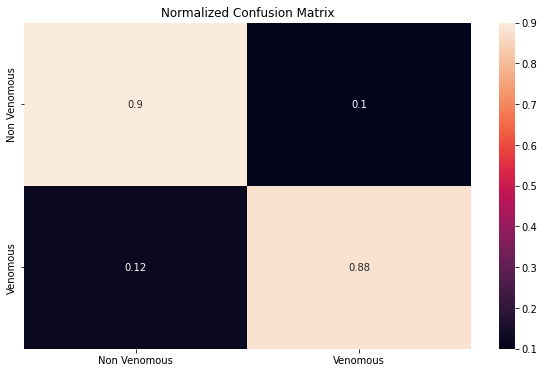

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()

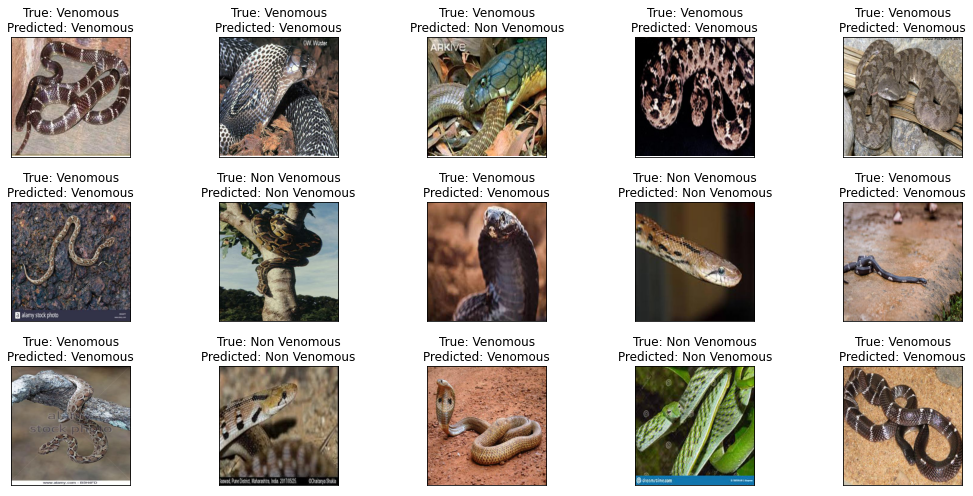

In [22]:
# Display 15 picture of the dataset with their labels
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()